In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from programs.links_aansluiting import links_vectortree_aansluiting as lva
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('latin-1')
sys.stdout = stdout
print os.getcwd()
SAVE_OUTPUT = True

E:\Projects\Bachelorscriptie


In [2]:
links_files = []
links_files.append('locations_v3.csv')
links_files.append('LINKS_Zeeland_cleaned_2016_01_Persons.csv')
links_files.append('LINKS_Zeeland_cleaned_2016_01_Registrations.csv')

marijn_files = []
#marijn_files.append('geboorteaktenlatlon.txt')
marijn_files.append('huwelijksaktenlatlon.txt')
#marijn_files.append('overlijdensaktenlatlon.txt')
links_dataframes, marijn_dataframes, toponiemen = lva.load_data_files(links_files=links_files, marijn_files=marijn_files)

print "loaded files"
links_persons = links_dataframes['LINKS_Zeeland_cleaned_2016_01_Persons.csv']
links_locations = links_dataframes['locations_v3.csv']
links_registrations = links_dataframes['LINKS_Zeeland_cleaned_2016_01_Registrations.csv']

links_marriages = links_persons[links_persons.registration_maintype == 2]
print "got marriages"

links_marriage_certs = lva.create_links_dataframe(links_marriages, links_locations, links_registrations, toponiemen)

marijn_marriage_certs = marijn_dataframes["huwelijksaktenlatlon.txt"]
marijn_marriage_zeeland = marijn_marriage_certs[marijn_marriage_certs.province == "Zeeland"]

if SAVE_OUTPUT:
    links_marriage_certs.to_csv('datafiles/dataframes/working/links_marriage_df.csv', sep="|", index=False)
    marijn_marriage_zeeland.to_csv('datafiles/dataframes/working/marijn_marriage_zeeland.csv', sep="|", index=False)
    print "saved files"

loaded files
got marriages
saved files


In [3]:
marijn_ids = marijn_marriage_zeeland
links_ids = links_marriage_certs[['id_registration', 'mar_location', 'registration_day', 'registration_month', 'registration_year', 'registration_seq']]
links_ids.loc[:,'location_no'] = links_ids['mar_location']
links_ids[['registration_day', 'registration_month', 'registration_year', 'registration_seq']] = links_ids[['registration_day', 'registration_month', 'registration_year', 'registration_seq']].apply(lambda x: pd.to_numeric(x, errors='coerce'))


"""
    1. Alle plaatsnamen moeten naar kleine letters worden omgezet. De plaatsnamen 
    worden soms met hoofdletters geschreven, en soms niet --> fixed
    2. In de links database zijn noord-beveland en zuid-beveland voluit geschreven, in marijn
    zn data niet... --> fixed
    3. registratienummer moet naar integers --> fixed
"""
marijn_ids.loc[:,'municipality'] = marijn_ids.municipality.astype('str').str.strip().str.lower()
marijn_ids.loc[:,'registration_day'] = pd.to_numeric(marijn_ids.date.str.split('-').str.get(0), errors='coerce')
marijn_ids.loc[:,'registration_month'] = pd.to_numeric(marijn_ids.date.str.split('-').str.get(1) ,errors='coerce')
marijn_ids.loc[:,'registration_year'] = pd.to_numeric(marijn_ids.date.str.split('-').str.get(2), errors='coerce')
marijn_ids.loc[:,'registration_seq'] = pd.to_numeric(marijn_ids.sequence_no, errors='coerce')

locations = links_locations[['location_no', 'location']]
locations.loc[:,'location'] = locations.location.astype(str).str.strip().str.lower()

print locations[locations.location_no == 8520]

marijn_ids = pd.merge(marijn_ids, locations, left_on="municipality", right_on="location", how="left")

if SAVE_OUTPUT:
    marijn_ids.to_csv('datafiles/dataframes/working/marijn_working.csv', sep='|', index=False)

      location_no        location
2360         8520  domburg-binnen


In [4]:
links_ids_merged = pd.merge(links_ids, marijn_ids, how="left", on=["location_no", "registration_day", "registration_month", "registration_year", "registration_seq"])

matches = links_ids_merged[links_ids_merged.certificate_id.notnull()]

no_matches = links_ids_merged[links_ids_merged.certificate_id.isnull()]
no_matches[no_matches.mar_location == 4047].registration_year.unique()

array([1932, 1928, 1924, 1923, 1926, 1936, 1937, 1935, 1927, 1929, 1934,
       1930, 1931, 1933, 1925, 1825, 1798, 1854, 1799], dtype=int64)

In [5]:
if SAVE_OUTPUT:
    links_ids_merged.to_csv('datafiles/output/working/links_ids_merged.csv', sep="|")
    no_matches.to_csv('datafiles/output/working/not_matched.csv', sep="|")
    matches.to_csv('datafiles/output/working/matched.csv', sep="|")

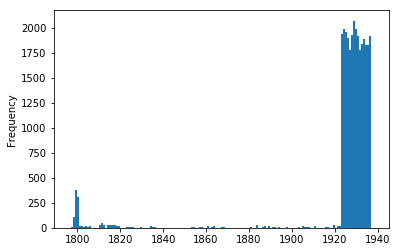

In [6]:
no_matches.registration_year.plot.hist(bins=150)
plt.show()

In [7]:
worst_locations = no_matches[no_matches.registration_year <= 1922]
worst_locations.location_no = worst_locations.location_no.round(0).astype('int64')

worst_locations.dtypes

id_registration               int64
mar_location                float64
registration_day              int64
registration_month            int64
registration_year             int64
registration_seq            float64
location_no                   int64
certificate_id              float64
certificate_type_num        float64
archive_id                  float64
certificate_type_text        object
date                         object
sequence_no                  object
province                     object
municipality                 object
lat                         float64
lon                         float64
access_no                    object
inventory_no                 object
groom_last_name              object
groom_prefix                 object
groom_patronym               object
groom_first_names            object
groom_age                   float64
groom_date_of_birth          object
groom_place_of_birth         object
bride_last_name              object
bride_prefix                

In [8]:
worst_locations = worst_locations[['id_registration','registration_day', 'registration_month', 'registration_year', 'registration_seq', 'location_no']]
worst_locations = pd.merge(worst_locations, links_locations, on='location_no')
worst_locations.sort_values(['id_registration'], ascending=False)

,id_registration,registration_day,registration_month,registration_year,registration_seq,location_no,Unnamed: 0,Unnamed: 0.1,location,municipality,province,region,country,lat,lon
1466,892407,6,9,1867,NaN,1444,620,620,Haamstede,Haamstede,Zeeland,NaN,Nederland,51.69749,3.74314
826,892120,29,8,1889,18.0,3344,1508,1508,Sint Annaland,Sint Annaland,Zeeland,NaN,Nederland,51.59977,4.10187
25,892106,13,10,1898,7.0,3152,1415,1415,Rilland-Bath,Rilland-Bath,Zeeland,NaN,Nederland,51.40178,4.20893
1171,892021,18,9,1816,6.0,3703,1698,1698,Veere,Veere,Zeeland,NaN,Nederland,51.54509,3.66407
138,891899,27,11,1861,68.0,4088,1912,1912,Zierikzee,Zierikzee,Zeeland,NaN,Nederland,51.65284,3.92407
1052,891890,7,5,1884,8.0,5434,2035,2035,Hulst,Hulst,Zeeland,NaN,Nederland,51.28025,4.05432
373,891437,21,12,1806,15.0,3577,1631,1631,Terneuzen,Terneuzen,Zeeland,NaN,Nederland,51.33712,3.82823
372,891294,25,2,1798,6.0,3577,1631,1631,Terneuzen,Terneuzen,Zeeland,NaN,Nederland,51.33712,3.82823
1158,891256,18,6,1799,32.0,1807,810,810,IJzendijke,IJzendijke,Zeeland,NaN,Nederland,51.32044,3.61607
1051,891081,1,3,1800,39.0,5434,2035,2035,Hulst,Hulst,Zeeland,NaN,Nederland,51.28025,4.05432


In [9]:
if SAVE_OUTPUT:
    worst_locations_grouped = worst_locations[['location_no', 'municipality']].groupby('location_no')
    worst_locations.to_csv('datafiles/output/working/worst_locations.csv', sep="|")
    

In [10]:
links_locations[links_locations.location_no == 3764]

,Unnamed: 0,Unnamed: 0.1,location_no,location,municipality,province,region,country,lat,lon
1728,1728,1728,3764,Vlissingen,Vlissingen,Zeeland,NaN,Nederland,51.45568,3.57649


In [11]:
# check of er registraties zijn zonder coördinaten...
matches[(pd.isnull(matches.lat)) | (pd.isnull(matches.lon))]

,id_registration,mar_location,registration_day,registration_month,registration_year,registration_seq,location_no,certificate_id,certificate_type_num,archive_id,...,mother_groom_first_names,father_bride_last_name,father_bride_prefix,father_bride_patronym,father_bride_first_names,mother_bride_last_name,mother_bride_prefix,mother_bride_patronym,mother_bride_first_names,location


In [12]:
certificaten = pd.merge(matches, links_marriage_certs, on="id_registration")
certificaten.columns

Index([u'id_registration', u'mar_location_x', u'registration_day_x',
       u'registration_month_x', u'registration_year_x', u'registration_seq_x',
       u'location_no_x', u'certificate_id', u'certificate_type_num',
       u'archive_id',
       ...
       u'lon_y', u'registration_maintype', u'registration_type', u'extract',
       u'registration_location', u'registration_day_y',
       u'registration_month_y', u'registration_year_y', u'registration_seq_y',
       u'registration_flag'],
      dtype='object', length=101)

In [13]:
marijn_ids.columns[:len(marijn_ids.columns)-6]

Index([u'certificate_id', u'certificate_type_num', u'archive_id',
       u'certificate_type_text', u'date', u'sequence_no', u'province',
       u'municipality', u'lat', u'lon', u'access_no', u'inventory_no',
       u'groom_last_name', u'groom_prefix', u'groom_patronym',
       u'groom_first_names', u'groom_age', u'groom_date_of_birth',
       u'groom_place_of_birth', u'bride_last_name', u'bride_prefix',
       u'bride_patronym', u'bride_first_names', u'bride_age',
       u'bride_date_of_birth', u'bride_place_of_birth',
       u'father_groom_last_name', u'father_groom_prefix',
       u'father_groom_patronym', u'father_groom_first_names',
       u'mother_groom_last_name', u'mother_groom_prefix',
       u'mother_groom_patronym', u'mother_groom_first_names',
       u'father_bride_last_name', u'father_bride_prefix',
       u'father_bride_patronym', u'father_bride_first_names',
       u'mother_bride_last_name', u'mother_bride_prefix',
       u'mother_bride_patronym', u'mother_bride_first_nam

In [14]:
koppeltabel = matches[['id_registration', 'certificate_id']]
koppeltabel.certificate_id = koppeltabel.certificate_id.round(0).astype('int64')
koppeltabel
if SAVE_OUTPUT:
    koppeltabel.to_csv('datafiles/output/working/koppeltabel.csv', index=False, header=False, sep=";")

In [15]:
links_marriage_certs[links_marriage_certs.id_registration == 703912][['location_no','location', 'mar_date', 'registration_seq', 'groom_last_name']]

,location_no,location,mar_date,registration_seq,groom_last_name
126211,1807,IJzendijke,26-04-1917,11,manhaave


In [16]:
matches[matches.id_registration == 848650][['certificate_id', 'municipality', 'date', 'sequence_no', 'groom_last_name', 'lat', 'lon']]

,certificate_id,municipality,date,sequence_no,groom_last_name,lat,lon
128335,1705054.0,ijzendijke,26-04-1917,11,Hecke,51.32044,3.61607
128336,1706082.0,ijzendijke,26-04-1917,11,Manhaave,51.32044,3.61607


In [17]:
marijn_marriage_certs[marijn_marriage_certs.certificate_id == 1802129][['date', 'sequence_no', 'municipality', 'groom_last_name']]

,date,sequence_no,municipality,groom_last_name
207440,18-01-1850,2,Poortvliet,Oostdijk


In [18]:
certs = lva.create_links_marriage_certs(links_marriage_certs)

In [19]:
certs

,certificate_id,certificate_type_num,archive_id,certificate_type_text,date,sequence_no,province,municipality,lat,lon,...,mother_groom_patronym,mother_groom_first_names,father_bride_last_name,father_bride_prefix,father_bride_patronym,father_bride_first_names,mother_bride_last_name,mother_bride_prefix,mother_bride_patronym,mother_bride_first_names
0,698558,2,NaN,NaN,09-06-1801,15,Zeeland,Zaamslag,NaN,NaN,...,NaN,johanna,huijssen,NaN,NaN,cornelis,gouwe,van der,NaN,elizabeth
1,698565,2,NaN,NaN,17-05-1861,8,Zeeland,Zaamslag,NaN,NaN,...,NaN,pieternella,hamer,den,NaN,cornelis,wege,van de,NaN,janneke
2,698612,2,NaN,NaN,01-08-1878,13,Zeeland,Zaamslag,NaN,NaN,...,NaN,janna,pooter,de,NaN,michiel,oppeneer,NaN,NaN,pieternella
3,698616,2,NaN,NaN,19-12-1901,27,Zeeland,Zaamslag,NaN,NaN,...,NaN,cornelia,bokx,de,NaN,gilles,dieleman,NaN,NaN,adriana
4,698644,2,NaN,NaN,25-06-1836,7,Zeeland,Zaamslag,NaN,NaN,...,NaN,adriana,doorn,van,NaN,jan,dronkers,NaN,NaN,pieternella
5,698700,2,NaN,NaN,05-02-1914,1,Zeeland,Zaamslag,NaN,NaN,...,NaN,maria,schoonakker,NaN,NaN,jacobus,verpoorte,NaN,NaN,elizabeth
6,698743,2,NaN,NaN,12-04-1932,1,Zeeland,Zaamslag,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,698762,2,NaN,NaN,22-06-1893,10,Zeeland,Zaamslag,NaN,NaN,...,NaN,suzanna,gerrits,NaN,NaN,andries,bruijne,de,NaN,tanneke
8,698904,2,NaN,NaN,02-04-1856,6,Zeeland,Zaamslag,NaN,NaN,...,NaN,santina,fouw,de,NaN,jan,deij,NaN,NaN,tannetje
9,699013,2,NaN,NaN,10-05-1846,8,Zeeland,Zaamslag,NaN,NaN,...,NaN,anna,alten,van,NaN,floris,michielsen,NaN,NaN,levina


In [20]:
if SAVE_OUTPUT:
    certs.to_csv('datafiles/dataframes/working/links_certificates.csv', sep="|", index=False)

In [21]:
pd.merge(links_locations, matches[['location_no', 'lat', 'lon']], how='left', on='location_no')

,Unnamed: 0,Unnamed: 0.1,location_no,location,municipality,province,region,country,lat_x,lon_x,lat_y,lon_y
0,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
1,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
2,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
3,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
4,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
5,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
6,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
7,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
8,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091
9,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091,51.54663,3.51091


In [22]:
links_locations['lon'] = links_locations['location_no'].map(matches[['location_no', 'lon']].set_index('location_no').to_dict()['lon'])

In [28]:
links_locations

,location_no,location,municipality,province,region,country,lat,lon
0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091
1,5,Aalburg,Aalburg,Noord-Brabant,NaN,Nederland,NaN,NaN
2,7,Aalsmeer,Aalsmeer,Noord-Holland,NaN,Nederland,NaN,NaN
3,10,Brakel,Brakel,Gelderland,NaN,Nederland,NaN,NaN
4,12,Aalst,Aalst (NB),Noord-Brabant,NaN,Nederland,NaN,NaN
5,14,Aalsum,Oostdongeradeel,Friesland,NaN,Nederland,NaN,NaN
6,15,Aalten,Aalten,Gelderland,NaN,Nederland,NaN,NaN
7,16,Aalter,NaN,NaN,Gent,België,NaN,NaN
8,17,Aardenburg,Aardenburg,Zeeland,NaN,Nederland,51.27393,3.44536
9,18,Aardswoud,Hoogwoud,Noord-Holland,NaN,Nederland,NaN,NaN


In [29]:

links_locations.to_csv('datafiles/links/locations_v3.csv', sep=";", index=False)

,Unnamed: 0,Unnamed: 0.1,location_no,location,municipality,province,region,country,lat,lon
0,0,0,4,Aagtekerke,Aagtekerke,Zeeland,NaN,Nederland,51.54663,3.51091
1,1,1,5,Aalburg,Aalburg,Noord-Brabant,NaN,Nederland,NaN,NaN
2,2,2,7,Aalsmeer,Aalsmeer,Noord-Holland,NaN,Nederland,NaN,NaN
3,3,3,10,Brakel,Brakel,Gelderland,NaN,Nederland,NaN,NaN
4,4,4,12,Aalst,Aalst (NB),Noord-Brabant,NaN,Nederland,NaN,NaN
5,5,5,14,Aalsum,Oostdongeradeel,Friesland,NaN,Nederland,NaN,NaN
6,6,6,15,Aalten,Aalten,Gelderland,NaN,Nederland,NaN,NaN
7,7,7,16,Aalter,NaN,NaN,Gent,België,NaN,NaN
8,8,8,17,Aardenburg,Aardenburg,Zeeland,NaN,Nederland,51.27393,3.44536
9,9,9,18,Aardswoud,Hoogwoud,Noord-Holland,NaN,Nederland,NaN,NaN
